In [1]:
import numpy as np
%matplotlib inline

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


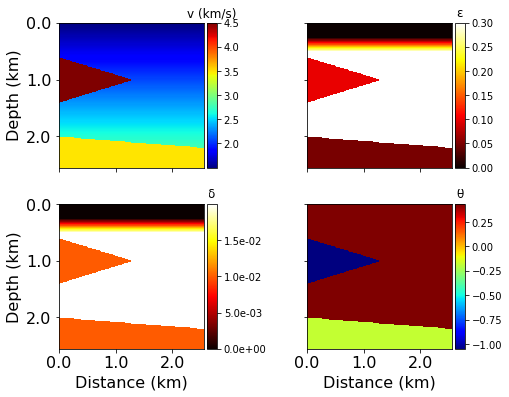

In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_velocity, plot_perturbation
from scipy import ndimage
from examples.seismic import Model, TimeAxis
from plot_parameters import plot



# Create true model from a preset
#model = create_model()

# Define a physical size
shape = (256, 256)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

space_order=8

#Load the velocity model and thomsem parameters
v = np.fromfile('models/new_models/vel.bin',dtype='float32')
epsilon = np.fromfile('models/new_models/epsilon.bin', dtype=np.float32)
delta = np.fromfile('models/new_models/delta.bin',dtype=np.float32)
theta = np.fromfile('models/new_models/theta.bin', dtype=np.float32)

v = np.reshape(v, shape)
epsilon = np.reshape(epsilon, shape)
delta = np.reshape(delta, shape)
theta = np.reshape(theta, shape)

# With the velocity, delta, epsilon, theta, phi and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 40 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=space_order, nbpml=40, epsilon=epsilon, delta=delta,
                  theta=theta,dtype=np.float64)
plot(v,epsilon,delta,theta)

In [3]:
from examples.seismic import Model, AcquisitionGeometry

# Source and receiver geometries
src_coordinates = np.empty((1, len(spacing)))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = model.origin[-1] + 2 * spacing[-1]

nrec = shape[0]

rec_coordinates = np.empty((nrec, len(spacing)))
rec_coordinates[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec_coordinates[:, 1] = np.array(model.domain_size)[1] * .5
rec_coordinates[:, -1] = model.origin[-1] + 2 * spacing[-1]

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates,
                                   t0=0.0, tn=4000., src_type='Ricker', f0=0.015)
dt = model.critical_dt
print(dt)

0.738


In [4]:
#src.coordinates.data[0, :]=src_coordinates[0]# just the first source
print(geometry.src.coordinates.data[:])
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic.tti import AnisotropicWaveSolver

# Solvers
solver_tti = AnisotropicWaveSolver(model, geometry, time_order=2,space_order=space_order)

[[1275.   20.]]


In [5]:
rec1, u, v, summary = solver_tti.forward()

Operator `ForwardTTI` run in 66.12 s


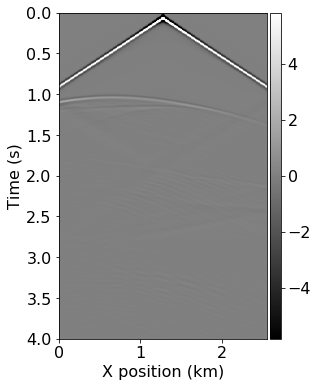

In [6]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec1.data, model, 0.0, 4000.)

In [7]:
srca_d , _, _, _ = solver_tti.adjoint(rec=rec1)

Operator `AdjointTTI` run in 144.54 s


In [8]:
# Adjoint test: Verify <Ax,y> matches  <x, A^Ty> closely
from devito import norm
term1 = np.dot(srca_d.data.reshape(-1), solver_tti.geometry.src.data)
#term2 = norm(rec1) ** 2
term2= np.linalg.norm(rec1.data)**2

In [9]:
print('<Ax,y>: %f, <x, A^Ty>: %f, difference: %4.4e, ratio: %f'
% (term1, term2, (term1 - term2)/term1, term1 / term2))

<Ax,y>: 940837.386094, <x, A^Ty>: 940837.386094, difference: 1.0146e-14, ratio: 1.000000
